In [1]:
import numpy as np
import pandas as pd
import rasterio
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader


class CloudSegmentationDataset(Dataset):
    def __init__(self, csv_file: Path) -> None:
        self.data = pd.read_csv(csv_file)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        row = self.data.iloc[idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1).astype(np.float32) / 65535.0  # 2D image
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)

        with rasterio.open(row["target"]) as src:
            target = src.read(1).astype(np.uint8)  # 2D mask

        return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.long)


dataset = CloudSegmentationDataset(
    Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\data\cloud_segmentation_dataset.csv")
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [24]:
dataset.data.head()

,red,green,blue,near_infrared,target
0,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...
1,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...
2,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...
3,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...
4,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...,C:\Users\giand\OneDrive\Documents\__packages__...


In [2]:
dataset.data.shape

(8400, 5)

c:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


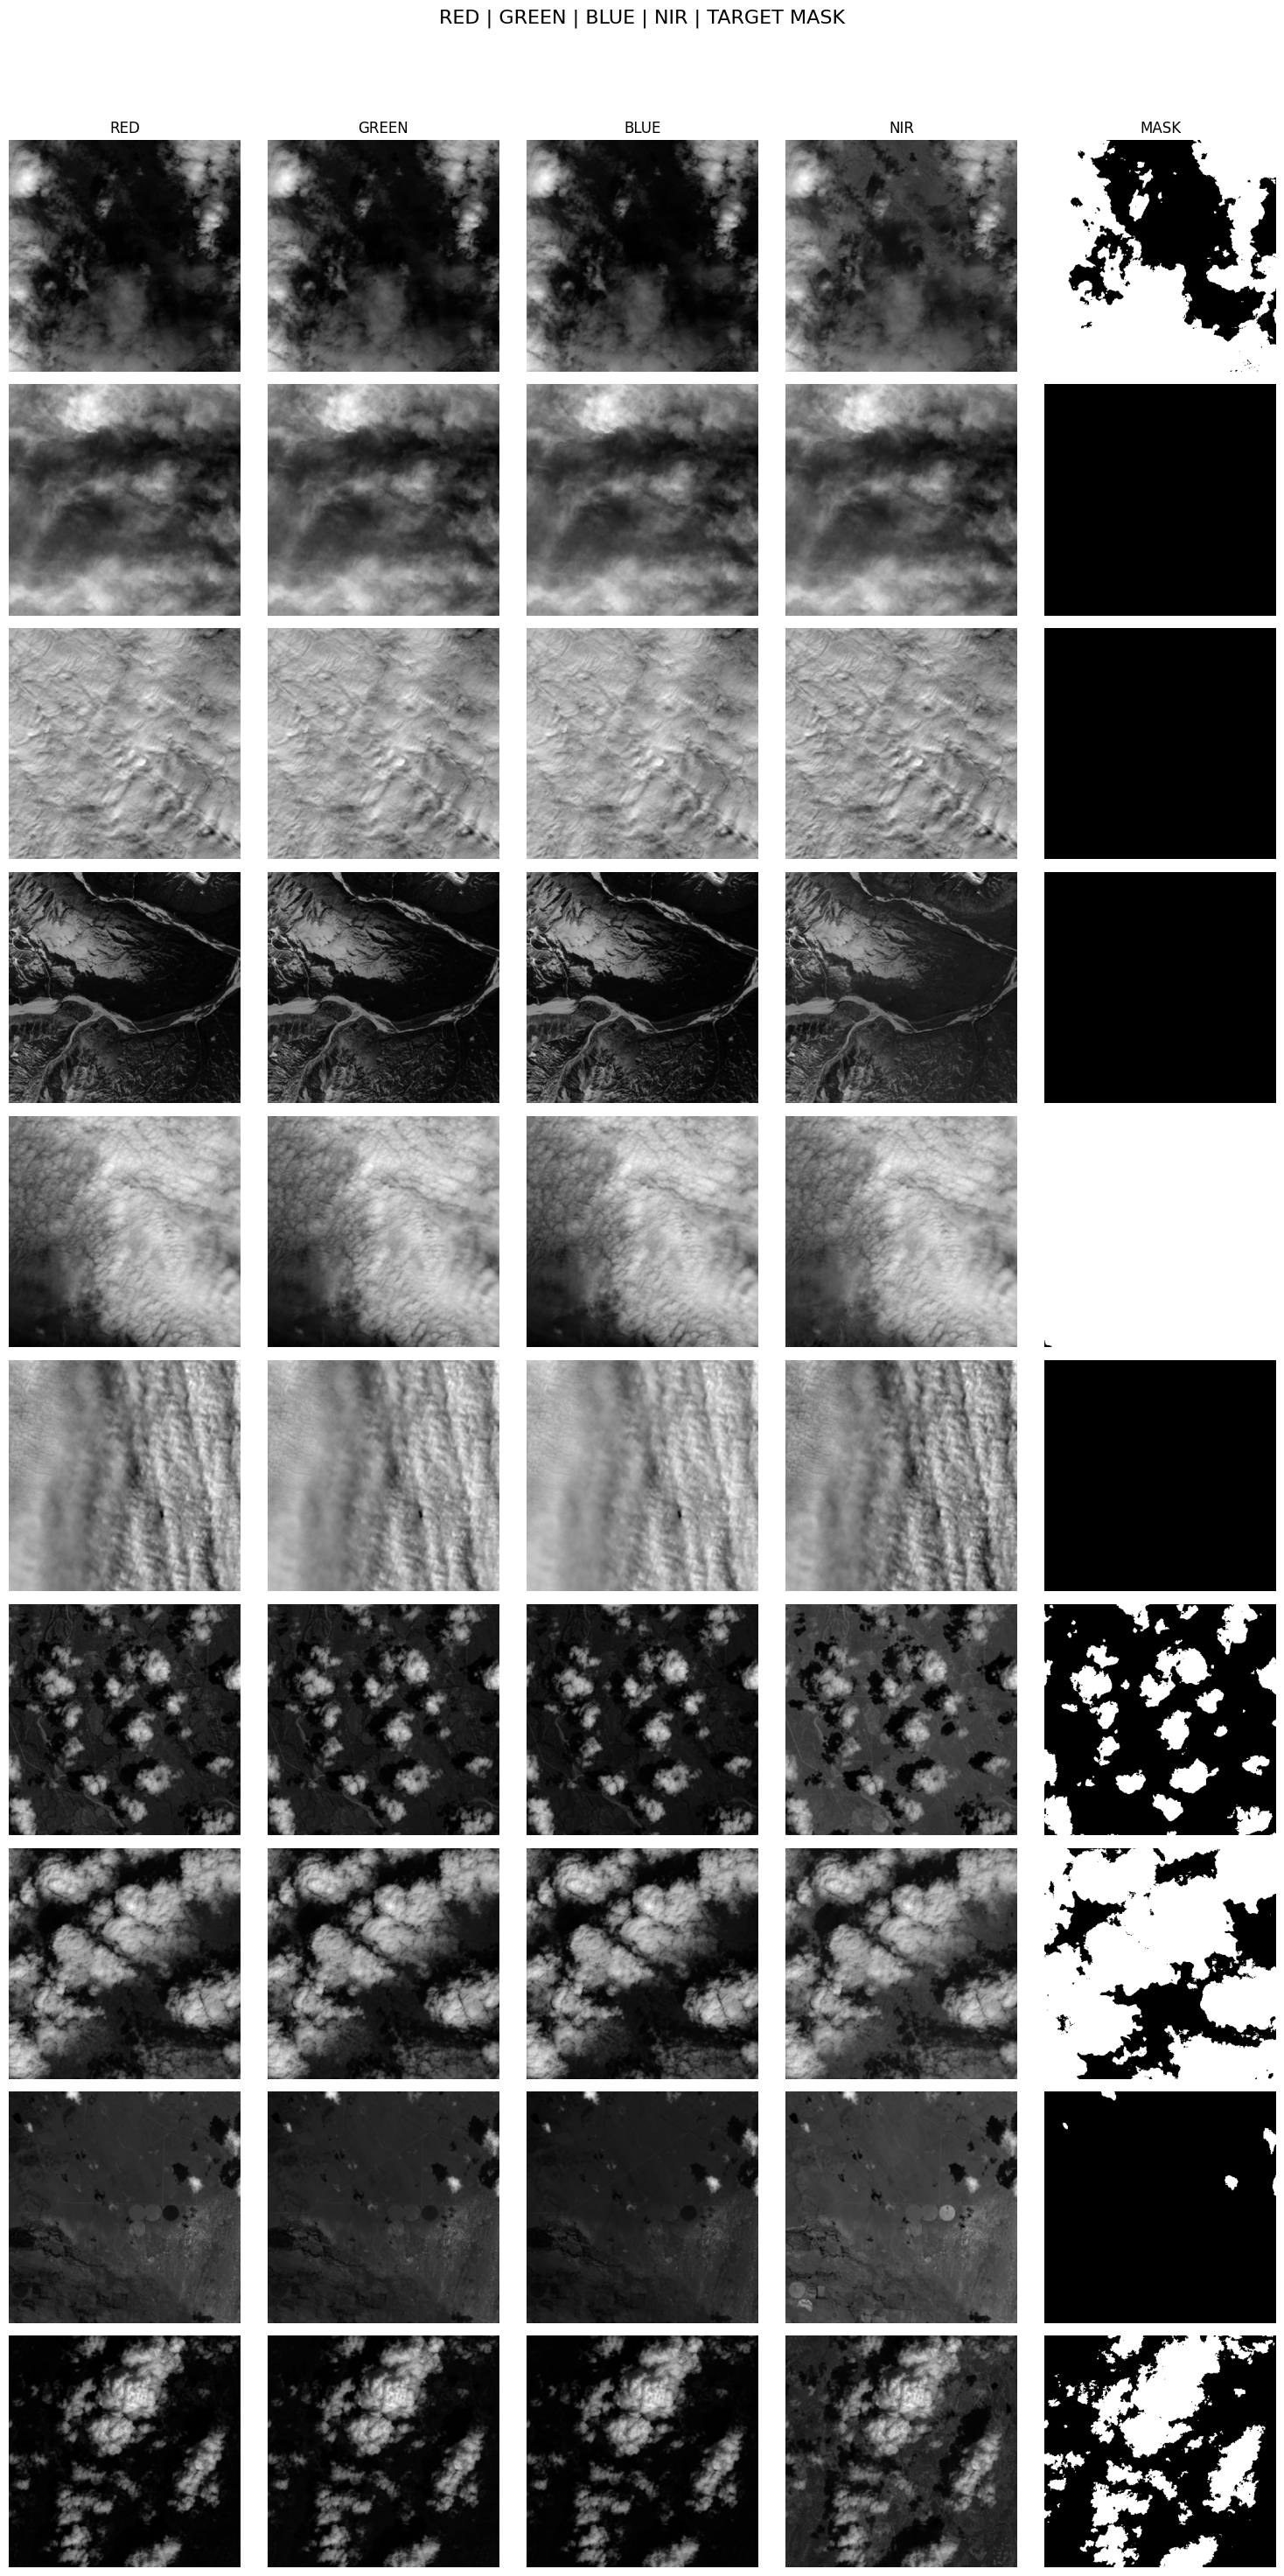

In [ ]:
import matplotlib.pyplot as plt


def plot_dataset_channels(dataset: CloudSegmentationDataset, n=5) -> None:
    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(15, 3 * n))
    fig.suptitle("RED | GREEN | BLUE | NIR | TARGET MASK", fontsize=16)

    for i in range(n):
        image, mask = dataset[i]
        for j in range(4):
            axes[i, j].imshow(image[j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0:
                axes[i, j].set_title(["RED", "GREEN", "BLUE", "NIR"][j])
        axes[i, 4].imshow(mask, cmap="gray")
        axes[i, 4].axis("off")
        if i == 0:
            axes[i, 4].set_title("MASK")

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


plot_dataset_channels(dataset, n=10)


OLD

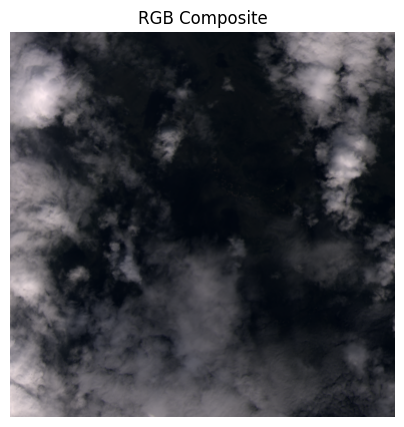

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def show_rgb_composite(dataset: CloudSegmentationDataset) -> None:
    file_entry = dataset.data.iloc[dataset.data.index[0]]  # Get the first entry
    channels = []
    for color in ["red", "green", "blue"]:
        img = Image.open(file_entry[color])
        arr = np.array(img)

        if arr.dtype != np.uint16:
            raise ValueError(f"{color} channel is not in 16-bit format.")

        channels.append(arr)

    # Check if all channels have the same dimensions
    h, w = channels[0].shape
    if not all(c.shape == (h, w) for c in channels):
        raise ValueError("Channels do not have the same dimensions.")

    rgb16 = np.stack(channels, axis=-1)  # shape (H, W, 3), dtype uint16

    rgb_visu = ((rgb16 - rgb16.min()) / (rgb16.max() - rgb16.min()) * 255).astype(np.uint8)

    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_visu)
    plt.title("RGB Composite")
    plt.axis("off")
    plt.show()


show_rgb_composite(dataset)

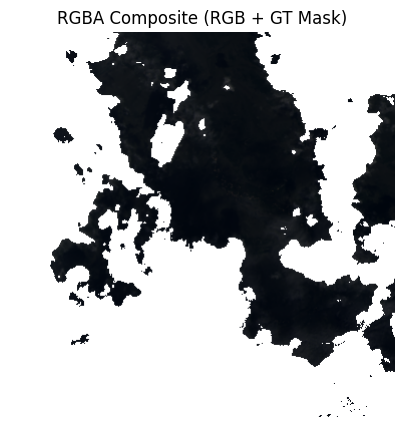

: 

In [ ]:
def show_rgb_with_gt_mask(dataset: CloudSegmentationDataset) -> None:
    file_entry = dataset.data.iloc[dataset.data.index[0]]  # Get the first entry
    channels = []
    for color in ["red", "green", "blue"]:
        img = Image.open(file_entry[color])
        arr = np.array(img, dtype=np.uint16)

        if arr.dtype != np.uint16:
            raise ValueError(f"{color} channel is not in 16-bit format.")

        channels.append(arr)

    h, w = channels[0].shape
    if not all(c.shape == (h, w) for c in channels):
        raise ValueError("RGB channels are not of the same size.")

    rgb16 = np.stack(channels, axis=-1)  # shape (H, W, 3), dtype uint16

    # gt becomes the alpha but we must invert it because the mask is white on clouds
    gt = np.array(Image.open(file_entry["target"]))
    if gt.shape != (h, w):
        raise ValueError("gt mask size does not match RGB images.")

    # Binariser l'alpha si nécessaire
    if gt.max() > 1:
        alpha = (gt > 0).astype(np.uint16) * 65535
    else:
        alpha = (gt > 0).astype(np.uint16) * 65535

    alpha = 65535 - alpha  # Invert alpha mask to show clouds as transparent

    # Normalized RGB and alpha channels for visualization
    rgb_visu = ((rgb16 - rgb16.min()) / (rgb16.max() - rgb16.min()) * 255).astype(np.uint8)
    alpha_visu = (alpha / 65535 * 255).astype(np.uint8)
    rgba_visu = np.dstack((rgb_visu, alpha_visu))

    plt.figure(figsize=(5, 5))
    plt.imshow(rgba_visu)
    plt.title("RGBA Composite (RGB + GT Mask)")
    plt.axis("off")
    plt.show()


show_rgb_with_gt_mask(dataset)

In [28]:
import pandas as pd
import rasterio
import numpy as np


def scan_dataset_stats(csv_path):
    df = pd.read_csv(csv_path)

    stats = {
        "index": [],
        "positive_ratio": [],
        "red_mean": [],
        "red_std": [],
        "red_min": [],
        "red_max": [],
    }

    for idx, row in df.iterrows():
        try:
            with rasterio.open(row["target"]) as tgt_src:
                target = tgt_src.read(1).astype(np.float32)
                if target.max() > 1.0:
                    target = target / 255.0
                pos_ratio = float(target.sum() / target.size)
        except:
            pos_ratio = None

        try:
            with rasterio.open(row["red"]) as red_src:
                red = red_src.read(1).astype(np.float32)
                red_mean = float(red.mean())
                red_std = float(red.std())
                red_min = float(red.min())
                red_max = float(red.max())
        except:
            red_mean = red_std = red_min = red_max = None

        stats["index"].append(idx)
        stats["positive_ratio"].append(pos_ratio)
        stats["red_mean"].append(red_mean)
        stats["red_std"].append(red_std)
        stats["red_min"].append(red_min)
        stats["red_max"].append(red_max)

    return pd.DataFrame(stats)


# Run the analysis on the uploaded CSV
csv_path = r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\data\cloud_segmentation_dataset.csv"
dataset_stats = scan_dataset_stats(csv_path)

c:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [29]:
dataset_stats

,index,positive_ratio,red_mean,red_std,red_min,red_max
0,0,0.626180,14248.019531,7175.635742,6354.0,44263.0
1,1,1.000000,13380.330078,2276.587891,8755.0,20651.0
2,2,1.000000,22955.123047,1470.636719,14644.0,28318.0
3,3,0.000000,12562.964844,5861.743652,6366.0,42511.0
4,4,0.999681,20266.921875,4823.113281,8385.0,30233.0
...,...,...,...,...,...,...
8395,8395,0.006504,181.091446,2249.852051,0.0,35693.0
8396,8396,0.000000,0.000000,0.000000,0.0,0.0
8397,8397,0.000000,0.000000,0.000000,0.0,0.0
8398,8398,0.000000,0.000000,0.000000,0.0,0.0
